# Rent the Runway: NLP

### Import Libraries and Data

In [1]:
#Data cleaning
import numpy as np
import pandas as pd

#NLP
import regex as re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')


#Modeling 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, f1_score


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm

np.random.seed(42)

#Warnings - to keep the notebook clean 
import warnings 
warnings.filterwarnings('ignore')
pd.options.display.max_columns= 5000

In [2]:
#Import the cleaned file without dummy columns
df = pd.read_csv('./rent_the_runway_cleaned_no_dummies.csv')
df.head()

,age,body_type,bust_size,category,fit,height,item_id,rating,rented_for,review_date,review_summary,review_text,size,user_id,weight
0,25,pear,34c,gown,0,65.0,937638,8,formal affair,2017-01-29,"Colorful, unique dress for a formal event",I'm glad I got the backup size of 10 because i...,20,402340,145
1,26,hourglass,32b,gown,1,66.0,604383,10,formal affair,2016-10-27,Stylist Review,You can't help but feel powerful in this numbe...,24,380920,160
2,38,straight & narrow,32a,dress,2,63.0,1505709,10,work,2017-05-22,"Easy to Wear, not much fuss",This runs big but it is still nice. The mater...,4,234255,108
3,29,athletic,34a,dress,1,61.0,127495,10,party,2014-11-05,Rented for my best friends bachelorette party....,The dress was perfect for fall/ winter weather...,4,763040,110
4,35,full bust,38d,dress,1,65.0,1001785,10,other,2015-09-30,This dress was perfect for Diner en Blanc. It ...,"It was a tad bit snug around the arms, but I h...",32,698342,220


In [3]:
#Drop the null values 
df.dropna(inplace=True)
    
#Trim the dataframe to only be text columns 
df= df[['fit', 'review_summary', 'review_text']]

In [4]:
df.shape

(29218, 3)

In [5]:
df.head()

,fit,review_summary,review_text
0,0,"Colorful, unique dress for a formal event",I'm glad I got the backup size of 10 because i...
1,1,Stylist Review,You can't help but feel powerful in this numbe...
2,2,"Easy to Wear, not much fuss",This runs big but it is still nice. The mater...
3,1,Rented for my best friends bachelorette party....,The dress was perfect for fall/ winter weather...
4,1,This dress was perfect for Diner en Blanc. It ...,"It was a tad bit snug around the arms, but I h..."


# NLP Pre-processing 

Since the results of the model are not so great, let's incorporate NLP on the review text. 

In [6]:
#Function to clean the text data 

def clean_text(df):

    df['full_review'] = df['review_summary'] + ' ' + df['review_text']                 
    #Combine selftext & title into one column 
    
    df['full_review'] = [str(words).lower() for words in df['full_review']]    
    #Change all the text to lowercase 
    
    df['full_review'] = [(re.sub(r'[^\w\s]','', word)) for word in df['full_review']]
    #remove puncutation. Got this regex code from stack overflow, checked it in regex101.com and put it in a list comp
    
    df['full_review'] = [(re.sub('[^A-Za-z]+', ' ', text)) for text in df['full_review']]
    #remove numbers
    
    return df

In [7]:
clean_text(df)

,fit,review_summary,review_text,full_review
0,0,"Colorful, unique dress for a formal event",I'm glad I got the backup size of 10 because i...,colorful unique dress for a formal event im gl...
1,1,Stylist Review,You can't help but feel powerful in this numbe...,stylist review you cant help but feel powerful...
2,2,"Easy to Wear, not much fuss",This runs big but it is still nice. The mater...,easy to wear not much fuss this runs big but i...
3,1,Rented for my best friends bachelorette party....,The dress was perfect for fall/ winter weather...,rented for my best friends bachelorette party ...
4,1,This dress was perfect for Diner en Blanc. It ...,"It was a tad bit snug around the arms, but I h...",this dress was perfect for diner en blanc it w...
5,1,Herve did not disappoint! A Looker!!,This was my first Herve and was recommended by...,herve did not disappoint a looker this was my ...
6,1,I made quite the exit in this stunning sparkle...,The reviews were VERY helpful in determining ...,i made quite the exit in this stunning sparkle...
7,1,Felt gorgeous,Runs pretty true to size. Zipper was hard to d...,felt gorgeous runs pretty true to size zipper ...
8,0,Simple and sexy,Cotton material is super comfortable. Very for...,simple and sexy cotton material is super comfo...
9,1,Everyone told me how great I looked in the dress!,I loved this dress! It doesn't have much give...,everyone told me how great i looked in the dre...


In [8]:
# #Lemmatize
# lm= WordNetLemmatizer()

# df['full_review'] = [" ".join([lm.lemmatize(w) for w in i.split()]) for i in df['full_review']]

In [9]:
#Check that the lemmatizer worked 
df[['full_review']].head()

,full_review
0,colorful unique dress for a formal event im gl...
1,stylist review you cant help but feel powerful...
2,easy to wear not much fuss this runs big but i...
3,rented for my best friends bachelorette party ...
4,this dress was perfect for diner en blanc it w...


In [10]:
#Export the combined and cleaned text column 
text = df[['full_review', 'fit']]
text.to_csv('./rent_the_runway_text.csv', index=False)

# NLP Modeling

In [11]:
#Declare X and y 

X = df['full_review']
y = df['fit']

In [12]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =42)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21913,)
(7305,)
(21913,)
(7305,)


In [14]:
#Function to run various models 

def fit_model(X, y, 
              vect_name = 'tfidf', vect_type = TfidfVectorizer(),
              model_name = 'logreg', model_type = LogisticRegression()):
    
    pipe = Pipeline([
        (vect_name, vect_type),
        (model_name, model_type)
    ])
    
    model = pipe.fit(X, y)
    
    score = model.score(X,y)
    
    # Print attributes
    
    print(f"For model: {model_type}")
#     print(f"Score: {score}")
    
    return model

In [15]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Evaluate training data
    preds_train = model.predict(X_train)
    score_train = model.score(X_train, y_train)

    # Evaluate testing data
    preds_test = model.predict(X_test)
    score_test = model.score(X_test, y_test)
    
    # Print results
    
    print(f'Train Score: {score_train:.4f}')
    print(f'Test Score: {score_test:.4f}')
    

In [16]:
# Tfidf & Logistic Regression

logreg = fit_model(X_train, y_train, 
                   vect_name='tfidf', vect_type=TfidfVectorizer(),
                   model_name='logreg',model_type=LogisticRegression())

evaluate_model(logreg, X_train, X_test, y_train, y_test)

For model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Train Score: 0.8184
Test Score: 0.7979


In [17]:
#Cvec & Logistic Regression

logreg2 = fit_model(X_train, y_train,
                    vect_name='cvec', vect_type=CountVectorizer(),
                    model_name='logreg', model_type=LogisticRegression())

evaluate_model(logreg2, X_train, X_test, y_train, y_test)

For model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Train Score: 0.8944
Test Score: 0.7807


In [18]:
#Tfidf & Naive Bayes

nb = fit_model(X_train, y_train,
               vect_name='tfidf', vect_type=TfidfVectorizer(),
               model_name='nb', model_type=MultinomialNB())

evaluate_model(nb, X_train, X_test, y_train, y_test)

For model: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Train Score: 0.7376
Test Score: 0.7259


In [19]:
#Cvec& Naive Bayes

nb2 = fit_model(X_train, y_train,
               vect_name='cvec', vect_type=CountVectorizer(),
               model_name='nb', model_type=MultinomialNB())

evaluate_model(nb2, X_train, X_test, y_train, y_test)

For model: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Train Score: 0.8301
Test Score: 0.7728


In [20]:
#Tfidf & KNN

knn = fit_model(X_train, y_train, 
                vect_name='tfidf', vect_type=TfidfVectorizer(),
                model_name='knn', model_type=KNeighborsClassifier())

evaluate_model(knn, X_train, X_test, y_train, y_test)

For model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Train Score: 0.7387
Test Score: 0.7266


In [21]:
#Cvec & KNN

knn2 = fit_model(X_train, y_train,
                 vect_name='cvec', vect_type=CountVectorizer(),
                 model_name='knn', model_type=KNeighborsClassifier())

evaluate_model(knn2, X_train, X_test, y_train, y_test)

For model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Train Score: 0.7747
Test Score: 0.7221


In [22]:
#Tfidf & Random Forests

rf = fit_model(X_train, y_train,
               vect_name='tfidf', vect_type=TfidfVectorizer(),
               model_name='rf', model_type=RandomForestClassifier())

evaluate_model(rf, X_train, X_test, y_train, y_test)

For model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Train Score: 0.9833
Test Score: 0.7514


In [23]:
#Cvec & Random Forests 

rf2 = fit_model(X_train, y_train,
                vect_name='cvec', vect_type=CountVectorizer(),
                model_name='rf', model_type=RandomForestClassifier())

evaluate_model(rf2, X_train, X_test, y_train, y_test)

For model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Train Score: 0.9861
Test Score: 0.7451


In [24]:
#Tfidf & gradient boosting

gb = fit_model(X_train, y_train, 
               vect_name='tfidf', vect_type=TfidfVectorizer(),
               model_name='gb', model_type= GradientBoostingClassifier())

evaluate_model(gb, X_train, X_test, y_train, y_test)

For model: GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Train Score: 0.8241
Test Score: 0.8027


In [25]:
#Cvec & gradient boosting

gb2 = fit_model(X_train, y_train, 
               vect_name='cvec', vect_type=CountVectorizer(),
               model_name='gb', model_type= GradientBoostingClassifier())

evaluate_model(gb2, X_train, X_test, y_train, y_test)

For model: GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Train Score: 0.8214
Test Score: 0.8016


# SMOTE & Gradient Boosting

In [26]:
# #Declare X and y 

# X2 = df[['full_review']]
# y2 = df['fit']

In [27]:
#Train Test Split
# X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state =42)

In [28]:
# tvec = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=5_000) 

# gb_Smote =GradientBoostingClassifier(learning_rate=0.1, 
#                                      max_depth=3, 
#                                      min_samples_leaf=1,
#                                      min_samples_split=2, 
#                                      n_estimators=100)

In [29]:
# from imblearn.over_sampling import SMOTE

# sm = SMOTE(kind='regular', sampling_strategy= 'auto', k_neighbors=5)

# #1 Fit and transform Count Vectorizer
# tvec_words = pd.DataFrame(tvec.fit_transform(X_train['full_review']).toarray(), columns=tvec.get_feature_names())

# #2 Fit SMOTE
# X2_train_res, y2_train_res = sm.fit_sample(tvec_words, y_train.ravel())

# X2_train_res.shape

# len(y_train_res)

In [30]:
#3 Fit Gradient Boosting
# gb_Smote.fit(X2_train_res, y2_train_res)

In [31]:
# print('After OverSampling, the shape of train_X: {}'.format(X2_train_res.shape))
# print('After OverSampling, the shape of train_y: {} \n'.format(y2_train_res.shape))

# print("After OverSampling, counts of label '2': {}".format(sum(y2_train_res==2)))
# print("After OverSampling, counts of label '1': {}".format(sum(y2_train_res==1)))
# print("After OverSampling, counts of label '0': {}".format(sum(y2_train_res==0)))

In [32]:
# # 4 Transform X_test
# X2_test_tvec = tvec.transform(X_test['full_review'])

# # Score model
# gb_Smote.score(X_test_tvec, y_test)

# Evaluate Results

The scores for Random Forests were best. The Count Vectorizer & Tfidf Vectorizer resulted in nearly the same scores. However, the Cvec model is slightly less overfit, which means less misclassifications. 

In [33]:
print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)

(7305,)
(21913,)
(7305,)
(21913,)


In [34]:
#Predictions 
predictions = gb.predict(X_test)

# Create DataFrame with column for predicted values
results = pd.DataFrame({'predicted': predictions, 
                        'actual': y_test})

#Find the rows with incorrect predictions 
misclass = results[results['predicted'] != results['actual']]
print(misclass.shape)
misclass.head()

(1441, 2)


,predicted,actual
22561,1,0
19216,1,2
27256,1,2
16438,1,0
16031,1,2


In [35]:
#Confusion Matrix 
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, 
                 predictions) 

#Here we can see the misclassified predictions 

array([[ 384,  633,   26],
       [ 105, 5123,   75],
       [  25,  577,  357]])

In [36]:
#Example of misclassified review 
df[df.index == 22561]

,fit,review_summary,review_text,full_review
22561,0,Not good for hippy girls,It fit to snug on my hips and loose on top. I ...,not good for hippy girls it fit to snug on my ...


In [37]:
df['full_review'].loc[22561]

'not good for hippy girls it fit to snug on my hips and loose on top i would not recommend for hippy girls it was kind of form fitting in a weird way would look best on tall and slender imo'

In [38]:
def get_top_n_words(corpus, n=None):                                            
#     List the top n words in a vocabulary according to occurrence in a text corpus.
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [39]:
#Apply the function to the data 

top_words = get_top_n_words(df['full_review'], n=None)

top_ten_words = pd.DataFrame(top_words[:10], columns={'word', 'count'})

top_ten_words

,count,word
0,dress,51099
1,fit,16305
2,size,12085
3,great,12056
4,perfect,11360
5,wore,10602
6,wear,10588
7,compliments,9587
8,comfortable,9252
9,little,8832


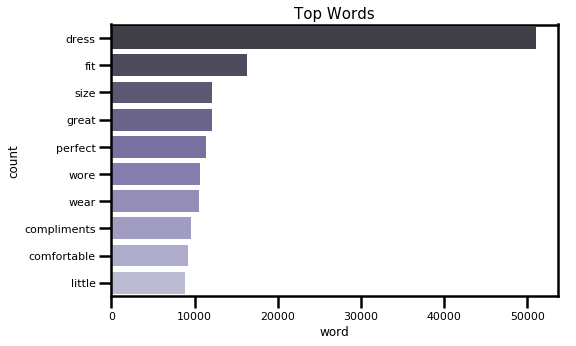

In [45]:
#Plot the top words 

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (8, 5))
sns.set_context("poster", font_scale = .5)
plt.title('Top Words', fontsize = 15)
sns.barplot(x='word', y ='count', palette='Purples_d', data = top_ten_words );

In [46]:
#save the model to disk for demo 
import pickle 

filename = 'final_nlp_model.sav'
pickle.dump(gb, open(filename, 'wb'))